# Bayesian Linear Regression
Notebook based on "Probabilistic Machine Learning: An introduction" by Kevin P. Murphy, chapter 11.7
For a theoretical introduction see also "Pattern Recognition and Machine Learning" by C. Bishop, chapter 3.3

In [118]:
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

Data generated according to: y = f(x)+ $\mathcal{N}(0,\sigma^2=1)$
where: f(x)=1+x+x^2

Model to fit: $\hat{y}=a+bx+cx^2$ with Normal pdf prior.

The posterior $p(\boldsymbol{w}|\mathcal{D})$ and the predictive distribution $p(y|x,\mathcal{D})$ can be computed analitically (See references). 

The problem of finding the maximum of the posterior $\boldsymbol{w}_\text{MAP}$ is equivalent to a Ridge regression problem

In [126]:


polydeg = 2  # Degree of design matrix
alph = 0.001  # Alpha of ridge regression. alph=sigma2aleatoricnoise/sigm2prior
num_samples = 25  # Number of sample coefficients to draw and use for prediction
visibility = 0.5  # Transparency of plotted lines - in case we wish to plot a bunch.


np.random.seed(12)
xtrain = np.array([ -2.,2.5])
#xtrain = np.array([ -2.,1,2.5])
#xtrain = np.linspace(-3, 3, 20)
xtest = np.linspace(-3, 3, 100)
sigma = 1


def fun(x):
    return 1+ x +x**2


ytrain = fun(xtrain) + np.random.normal(0,sigma,[xtrain.shape[0]]) 
ytest = fun(xtest) + np.random.normal(0,sigma, [xtest.shape[0]])


def reshape(x):
    return np.asarray(x).reshape(-1, 1)


xtrain = reshape(xtrain)
xtest = reshape(xtest)
ytrain = reshape(ytrain)
ytest = reshape(ytest)

In [127]:
def poly_basis(x, deg):
    # Expands a vector to a polynomial design matrix: from a constant to the deg-power
    return np.column_stack([x**deg for deg in range(0, deg + 1)])

In [128]:
xtrainp = poly_basis(xtrain, polydeg)
xtestp = poly_basis(xtest, polydeg)

# Declare and fit linear regression model
linreg = Ridge(alpha=alph, fit_intercept=False)
linreg.fit(xtrainp, ytrain)

sigma2=sigma*sigma
priorprec=sigma2/alph

# Determine coefficient distribution
wmle = linreg.coef_.reshape(
    -1,
)  # Mean of coefficients

wcov = sigma2 * np.linalg.inv(
    np.diag(np.array([alph] * (polydeg + 1))) + xtrainp.T.dot(xtrainp)
)  # Covariance of coefficients

print('posterior covariance matrix: \n',wcov)

wcov_inv =np.diag(np.array([priorprec] * (polydeg + 1)))+(1/sigma2)*xtrainp.T.dot(xtrainp)
posterior_bayes = np.random.multivariate_normal(mean=wmle, cov=wcov,size=num_samples)

samples = sigma2 * posterior_bayes

# Sample predictions according to samples of coefficients
prediction_samples = xtestp.dot(samples.T)

ypred_mle = linreg.predict(xtestp)  # MLE prediction
noise_mle = sigma2  # MLE noise estimation
print()
print('MAP: \n',wmle)
print()
print('prior varaince:',priorprec)



posterior covariance matrix: 
 [[ 952.38321976   95.22509595 -190.47135324]
 [  95.22509595    9.62994055  -19.05954998]
 [-190.47135324  -19.05954998   38.11345881]]

MAP: 
 [0.16538293 0.6639562  1.15889274]

prior varaince: 1000.0


In [129]:
def make_plot(ypreds, save_name, title, lowerb=None, upperb=None):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True,)

    plt.errorbar((xtrain).T[0], (ytrain).T[0], yerr=np.zeros(len(ytrain))+sigma2, fmt="o", color="black",label="Training Data")

    errlogi = lowerb is not None or upperb is not None  # Determines where we will be plotting error bars as well
    if errlogi:
        errspacing = [int(round(s)) for s in np.linspace(0, xtest.shape[0] - 1, 30)]
        errspacing_reshaped = np.reshape(np.array(errspacing), (1, len(errspacing)))
        yerr = [list(lowerb[np.array(errspacing)]), list(upperb[np.array(errspacing)])]
        plt.errorbar(
            xtest[errspacing_reshaped][0, :, :],
            ypreds[np.array(errspacing), 0],
            yerr=yerr,
            color="blue",
            linewidth=0.2,
            label="Prediction",
        )
        plt.fill_between(xtest[:, 0], ypreds[:, 0] + lowerb, ypreds[:, 0] - upperb, alpha=0.4)
    else:
        for j in range(ypreds.shape[1]):
            ax.plot(xtest, ypreds[:, j], color="b", linewidth=0.3, label="Prediction", alpha=visibility)
    
    plt.fill_between(xtest[:, 0], ypreds[:, 0] + sigma2, ypreds[:, 0] - sigma2,color="forestgreen",label="Aleatoric", alpha=0.6)

    plt.legend(loc=9)
    plt.xlabel("X")
    plt.ylabel("Y")
 

Plot: Mean prediction $\pm \sigma$ 

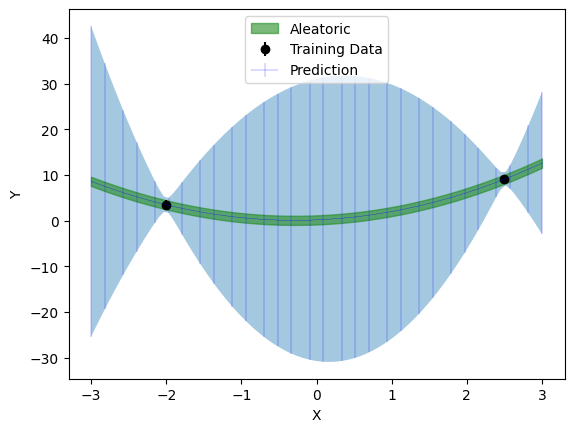

In [130]:
postnoise = np.array([np.sqrt(sigma2 + xtestp[i, :].T.dot(wcov.dot(xtestp[i, :]))) for i in range(xtestp.shape[0])])
make_plot(ypred_mle, "linregPostPredBayes", "Posterior_predictive", postnoise, postnoise)

#plt.savefig('provaII.pdf')

In [124]:
xtrainI=xtrain
ytrainI=ytrain
xtestI=xtest
ypred_mleI=ypred_mle
postnoiseI=postnoise
ypred_mleI=ypred_mle
sigma2I=sigma2

# Adding one more point

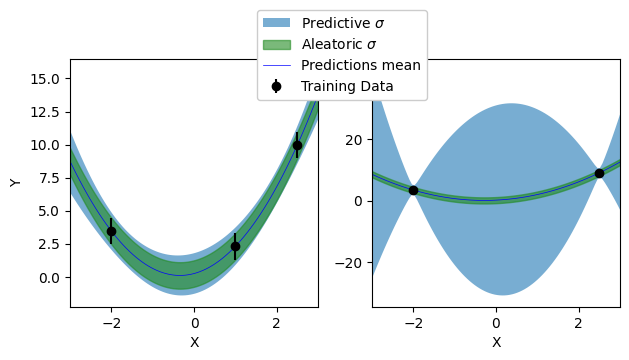

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.fill_between(xtestI[:, 0], ypred_mleI[:, 0] + postnoiseI, ypred_mleI[:, 0] - postnoiseI, alpha=0.6,label="Predictive $\sigma$")
ax1.fill_between(xtestI[:, 0], ypred_mleI[:, 0] + sigma2I**0.5, ypred_mleI[:, 0] - sigma2I**0.5,color="forestgreen",label="Aleatoric $\sigma$", alpha=0.6)
ax1.errorbar((xtrainI).T[0], (ytrainI).T[0], yerr=np.zeros(len(ytrainI))+sigma2I, fmt="o", color="black",label="Training Data")
ax1.plot(xtestI, ypred_mleI[:, :], color="b", linewidth=0.5, label="Predictions mean")
ax1.set_box_aspect(1)

#ax1.legend(loc=9)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_xlim(-3,3.)

ax2.fill_between(xtest[:, 0], ypred_mle[:, 0] + postnoise, ypred_mle[:, 0] - postnoise, alpha=0.6)
ax2.fill_between(xtest[:, 0], ypred_mle[:, 0] + sigma2**0.5, ypred_mle[:, 0] - sigma2**0.5,color="forestgreen",label="Aleatoric", alpha=0.6)
ax2.errorbar((xtrain).T[0], (ytrain).T[0], yerr=np.zeros(len(ytrain))+sigma2, fmt="o", color="black",label="Training Data")
ax2.plot(xtest, ypred_mle[:, :], color="b", linewidth=0.5, label="Prediction")
ax2.set_box_aspect(1)

#ax2.legend(loc=9)
ax2.set_xlabel("X")
#ax2.set_ylabel("Y")
ax2.set_xlim(-3,3.)



handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center') #bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5
fig.legend(handles, labels, bbox_to_anchor=(0.675,0.86), loc=1, borderaxespad=0., framealpha=1)
plt.tight_layout()
plt.savefig('bayes_regr.pdf')